# TP 6 – Arbre binomial et comparaison avec Black-Scholes

Ce TP illustre le module `pricing.lattice` de fypy.

Objectifs :
- dériver la construction d'un arbre binomial recombina nt sous Black-Scholes;
- obtenir les probabilités risque-neutre et le schéma de valorisation backward;
- comparer numériquement le prix de l'arbre au prix analytique Black-Scholes;
- étudier le cas américain (exercice anticipé) où il n'y a pas de formule fermée simple.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fypy.pricing.lattice.BinomialLattice import binomial_lattice_black_scholes
from fypy.pricing.analytical.black_scholes import black_scholes_price

%matplotlib inline

/home/salok1/RepoFinal/FYPY/fypy/pricing/analytical/black_scholes.py:5: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.4)
  from scipy.stats import norm


## 1. Construction de l'arbre binomial sous Black-Scholes

On part du modèle lognormal sous la mesure risque neutre :
\[
dS_t = (r - q) S_t \, dt + \sigma S_t \, dW_t.
\]

Sur un pas de temps \( \Delta t = T / M \), on approxime le mouvement par un processus à deux états :
\[
S_{t+\Delta t} = S_t \times \begin{cases}
u & \text{avec prob. } p, \\
d & \text{avec prob. } 1-p,
\end{cases}
\]
avec typiquement :
\[
u = e^{\sigma \sqrt{\Delta t}}, \quad d = 1/u.
\]

La probabilité **risque-neutre** \( p \) est choisie pour reproduire la dérive sans risque \( r \) :
\[
E[S_{t+\Delta t} \mid S_t] = S_t e^{(r - q)\Delta t} = S_t (p u + (1-p) d).
\]
On en déduit :
\[
p = \frac{e^{(r - q) \Delta t} - d}{u - d}.
\]

La fonction `binomial_lattice_black_scholes` implémente exactement ce schéma avec actualisation backward des payoffs.

Prix Black-Scholes (call européen) : 9.413403383853023
M =   5  ->  prix arbre = 9.796472
M =  10  ->  prix arbre = 9.217851
M =  25  ->  prix arbre = 9.489075
M =  50  ->  prix arbre = 9.373839
M = 100  ->  prix arbre = 9.393596
M = 200  ->  prix arbre = 9.403493


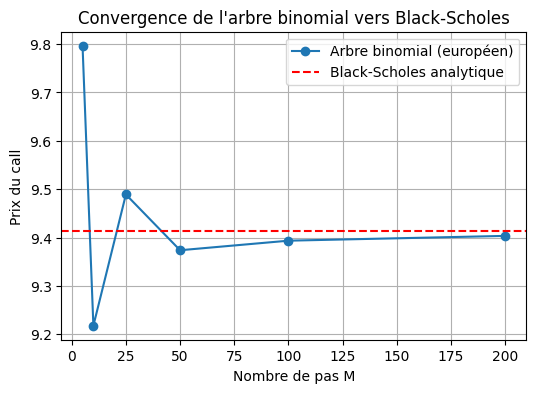

In [2]:
# Paramètres communs
S0 = 100.0
K = 100.0
sigma = 0.2
r = 0.03
q = 0.0
T = 1.0

# Prix analytique (call européen)
disc = np.exp(-r * T)
div_disc = np.exp(-q * T)
prix_bs = black_scholes_price(S=S0, K=K, is_call=True, vol=sigma, disc=disc, T=T, div_disc=div_disc)
print('Prix Black-Scholes (call européen) :', prix_bs)

# Prix par arbre binomial pour différents nombres de pas
M_list = [5, 10, 25, 50, 100, 200]
prix_lattice = []

for M in M_list:
    prix = binomial_lattice_black_scholes(S_0=S0,
                                          K=K,
                                          r=r,
                                          T=T,
                                          sigma=sigma,
                                          M=M,
                                          call=1,
                                          is_american=False)
    prix_lattice.append(prix)
    print(f'M = {M:3d}  ->  prix arbre = {prix:.6f}')

plt.figure(figsize=(6, 4))
plt.plot(M_list, prix_lattice, 'o-', label='Arbre binomial (européen)')
plt.axhline(prix_bs, color='red', linestyle='--', label='Black-Scholes analytique')
plt.xlabel('Nombre de pas M')
plt.ylabel('Prix du call')
plt.title('Convergence de l\'arbre binomial vers Black-Scholes')
plt.grid(True)
plt.legend()
plt.show()

On observe la **convergence** du prix de l'arbre binomial vers le prix analytique lorsque le nombre de pas augmente.

## 2. Options américaines : l’intérêt de l’arbre

Pour un call européen sur un actif sans dividende sous Black-Scholes, il n’y a pas d’intérêt à exercer avant
l’échéance. En revanche, pour un **put américain**, ou un call sur actif versant dividende, l’exercice anticipé peut
être optimal.

L’arbre binomial permet d’évaluer ce choix à chaque nœud :
- on compare la valeur de continuation (espérance actualisée des nœuds fils);
- à la valeur d’exercice immédiat \( (K - S)^+ \) pour un put;
- on prend le maximum des deux (principe du *dynamic programming*).

In [3]:
# Comparaison put européen / américain par arbre binomial
K_put = 100.0
M = 200

put_euro = binomial_lattice_black_scholes(S_0=S0,
                                          K=K_put,
                                          r=r,
                                          T=T,
                                          sigma=sigma,
                                          M=M,
                                          call=0,
                                          is_american=False)

put_amer = binomial_lattice_black_scholes(S_0=S0,
                                          K=K_put,
                                          r=r,
                                          T=T,
                                          sigma=sigma,
                                          M=M,
                                          call=0,
                                          is_american=True)

print('Put européen (arbre)  :', put_euro)
print('Put américain (arbre) :', put_amer)
print('Prime de liquidité due à l\'exercice anticipé =', put_amer - put_euro)

Put européen (arbre)  : 6.448046547173977
Put américain (arbre) : 6.738200801787214
Prime de liquidité due à l'exercice anticipé = 0.2901542546132374


L’arbre permet donc de traiter naturellement des produits où l’exercice anticipé ou des conditions sur le chemin
rendent l’approche analytique complexe ou impossible.

**Pour aller plus loin :**
- étudier l’effet d’un dividende \( q > 0 \) sur le call américain;
- augmenter encore `M` et mesurer l’impact sur la différence euro/américain;
- comparer le put européen obtenu par arbre à un put européen Black-Scholes analytique.